# Applied Data Science Capstone Project: Opening a Jazz Club in Toronto

## Introduction:
Toronto, Ontario is a vibrant city geographically situated between Detroit and Montreal, both of which are renowned for their respective jazz scenes. Despite being a major metropolitan hub, Toronto has not achieved this same distinction. As such, Toronto presents an opportunity for an enterprising club owner/restaurateur to open a new jazz club.

The purpose of this project is to determine the optimal location(s) for a club that serves a blend of southern barbecue, soul food, and Cajun/creole cuisine while providing a space for live musical performances by local and touring jazz and blues artists.

Using data acquired via the Foursquare API, it will be determined which neighborhoods in the city would best serve as the location for this hypothetical establishment. The analysis will consist of using a clustering algorithm to analyze Toronto neighborhoods based on the types of venues present. 

## Install packages and import libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

!conda install lxml --yes

import json

from pandas.io.json import json_normalize

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         156 KB

The following packages will be UPDATED:

    certifi: 2019.6.16-py36_1  conda-forge --> 2019.6.16-py36_1 
    openssl: 1.1.1c-h516909a_0 conda-forge --> 1.1.1c-h7b6447c_1


certifi-2019.6.16    | 156 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4

## Data acquisition and cleaning

In [2]:
# scrape Wikipedia for Toronto neighborhood data
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)

In [3]:
df_html = pd.read_html(url, header=0, na_values=['Not assigned'])[0]
df_html.head()

,Postcode,Borough,Neighbourhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
# drop rows with empty 'Borough' values
df_html.dropna(subset=['Borough'], inplace=True)

# for rows with no 'Neighbourhood' value, use the 'Borough'
df_html[df_html['Neighbourhood'].isna()]

,Postcode,Borough,Neighbourhood
8,M7A,Queen's Park,NaN


In [5]:
df_html['Neighbourhood'].fillna(df_html['Borough'], inplace=True)
df_html[df_html['Borough'] == "Queen's Park"]

,Postcode,Borough,Neighbourhood
8,M7A,Queen's Park,Queen's Park


In [6]:
# group by 'Postcode' & 'Borough'
postcodes = df_html.groupby(['Postcode', 'Borough']).Neighbourhood.agg([('Neighbourhood', ', '.join)])
postcodes.reset_index(inplace=True)
postcodes.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
# drop rows with no 'Borough' value; check dataset shape
df_html.dropna(subset=['Borough'], inplace=True)
df_html.shape

(211, 3)

In [8]:
# save as csv file
postcodes.to_csv('Toronto Postal Codes.csv')

In [9]:
# read csv from hyperlink and load into new datframe to get geographic coordinates
url_csv = 'http://cocl.us/Geospatial_data'
coordinates = pd.read_csv(url_csv)
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
# use cleaned Toronto neighborhood data to create a new dataframe
toronto_neighborhoods = pd.read_csv('Toronto Postal Codes.csv', index_col=[0])
toronto_neighborhoods.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [11]:
# rename columns and merge datasets
toronto_neighborhoods.rename(columns={'Postcode': 'Postal Code'}, inplace=True)
neighborhood_coordinates = pd.merge(toronto_neighborhoods, coordinates, on='Postal Code')
neighborhood_coordinates.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [12]:
# export to new csv file
neighborhood_coordinates.to_csv('Toronto Postal Codes2.csv')

In [13]:
# read csv into new dataframe
df = pd.read_csv('Toronto Postal Codes2.csv', index_col=0)
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [14]:
# get shape of dataframe
df.shape

(103, 5)

In [15]:
# rename columns for consistency (and to placate American English-speakers)
df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)

In [16]:
# count neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    18
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Queen's Park         1
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [17]:
# select relevant data for a new dataframe
toronto = df[df['Borough'].str.contains('Toronto')]
toronto.reset_index(inplace=True)
toronto.drop('index', axis=1, inplace=True)
toronto.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [18]:
# count neighborhoods in each Toronto borough
toronto.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    18
East Toronto         5
West Toronto         6
Name: Neighborhood, dtype: int64

In [19]:
# acquire coordinates of Toronto city center by taking mean latitude & longitude values from the dataset
lat_toronto = toronto['Latitude'].mean()
lon_toronto = toronto['Longitude'].mean()
print(lat_toronto, lon_toronto)

43.667262184210514 -79.38988323421053


## Create a map of Toronto neighborhoods

In [20]:
# create list of boroughs
boroughs = toronto['Borough'].unique().tolist()

# assign colors to borough map markers
borough_color = {}
for borough in boroughs:
    borough_color[borough] = '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

In [21]:
# create map object in folium
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=12)

# add markers
for lat, lng, borough, neighborhood in zip(toronto['Latitude'],
                                          toronto['Longitude'],
                                          toronto['Borough'],
                                          toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker([lat, lng],
                       radius=5,
                       popup=label,
                       color=borough_color[borough],
                       fill_color=borough_color[borough],
                       fill_opacity=0.7).add_to(map_toronto)

map_toronto

## Use the Foursquare API to explore venues in Toronto's neighborhoods

In [22]:
# establish Foursquare credentials
CLIENT_ID = 'HF5GLJUDF23RP45OKQEWCQLOCEQ1NX0YMF2V3JZ43J33WC4H'
CLIENT_SECRET = 'TT55LYAH01ZEIE0E55FVAV3KNQAA3YMKPFOYT1NWOYQTBTAH'
VERSION = '20180605'
LIMIT = 100
radius = 500

In [23]:
# use the following function to get data on Toronto venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url_api = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url_api).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                latitudes=toronto['Latitude'],
                                longitudes=toronto['Longitude'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [25]:
# get shape of resulting dataframe
toronto_venues.shape

(1711, 7)

In [26]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [27]:
# count venues in each neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"Brockton, Exhibition Place, Parkdale Village",23,23,23,23,23,23
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",17,17,17,17,17,17
"Cabbagetown, St. James Town",44,44,44,44,44,44
Central Bay Street,85,85,85,85,85,85
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,16,16,16,16,16,16


In [28]:
# use one hot encoding to analyze Toronto neighborhoods
onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighborhood column back to dataframe
onehot['Neighborhood'] = toronto_venues['Neighborhood']

# move neighborhood column to first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [29]:
onehot.shape

(1711, 238)

In [30]:
# get the mean frequency of each venue category (i.e., the proportion of venues in that category in a given neighborhood)
toronto_grouped = onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.00,0.010000,0.010000,0.000000,0.030000,0.0000,0.0000,0.000000,0.0000,0.000000,0.020000,0.000000,0.040000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.00,0.030000,0.010000,0.000000,0.000000,0.050000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.080000,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.020000,0.000000,0.030000,0.000000,

In [31]:
toronto_grouped.shape

(38, 238)

In [32]:
# list the 5 most common venue types per neighborhood
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print('----'+hood+'----')
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
            venue  freq
0     Coffee Shop  0.08
1            Café  0.05
2      Steakhouse  0.04
3             Bar  0.04
4  Cosmetics Shop  0.03


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2      Farmers Market  0.04
3              Bakery  0.04
4  Seafood Restaurant  0.04


----Brockton, Exhibition Place, Parkdale Village----
               venue  freq
0        Yoga Studio  0.09
1        Coffee Shop  0.09
2               Café  0.09
3     Breakfast Spot  0.09
4  Convenience Store  0.04


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0    Light Rail Station  0.12
1           Yoga Studio  0.06
2         Auto Workshop  0.06
3  Gym / Fitness Center  0.06
4         Garden Center  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airport Service  0.18
1    Ai

In [33]:
# sort venues in descending order of frequency
def most_common(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
# create new dataframe with top ten venue types for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for i in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    except:
        columns.append('{}th Most Common Venue'.format(i+1))

# create new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for i in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[i, 1:] = most_common(toronto_grouped.iloc[i, :], num_top_venues)
    
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,Restaurant,Asian Restaurant,Burger Joint,American Restaurant,Hotel
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Bakery,Steakhouse,Cheese Shop,Seafood Restaurant,Café,Fish Market
2,"Brockton, Exhibition Place, Parkdale Village",Yoga Studio,Breakfast Spot,Café,Coffee Shop,Bar,Burrito Place,Restaurant,Caribbean Restaurant,Climbing Gym,Pet Store
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place,Restaurant
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Bar,Plane,Coffee Shop,Sculpture Garden,Boutique,Boat or Ferry
5,"Cabbagetown, St. James Town",Café,Coffee Shop,Italian Restaurant,Pub,Pizza Place,Restaurant,Bakery,Grocery Store,Chinese Restaurant,Japanese Restaurant
6,Central Bay Street,Coffee Shop,Café,Ice Cream Shop,Italian Restaurant,Sandwich Place,Burger Joint,Sushi Restaurant,Middle Eastern Restaurant,Salad Place,Bubble Tea Shop
7,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Bar,Chinese Restaurant,Vietnamese Restaurant,Mexican Restaurant,Dumpling Restaurant,Bakery,Coffee Shop,Arts & Crafts Store
8,Christie,Café,Grocery Store,Park,Athletics & Sports,Baby Store,Italian Restaurant,Restaurant,Nightclub,Diner,Coffee Shop
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Gym,Smoke Shop,Bubble Tea Shop,Burger Joint,Café


## Cluster the neighborhoods based on the most popular venue categories

In [35]:
# use the elbow method to find the optimal k-value
toronto_clustering = toronto_grouped.drop('Neighborhood', 1)

sum_squares = []
values = range(1, 20)
for value in values:
    kmeans = KMeans(n_clusters=value)
    kmeans = kmeans.fit(toronto_clustering)
    sum_squares.append(kmeans.inertia_)

In [36]:
# visualize optimal k-value
optimal_k = pd.DataFrame(data=sum_squares, columns=['Sum of Squared Distances'], index=values)
optimal_k.rename_axis('k', axis='columns', inplace=True)

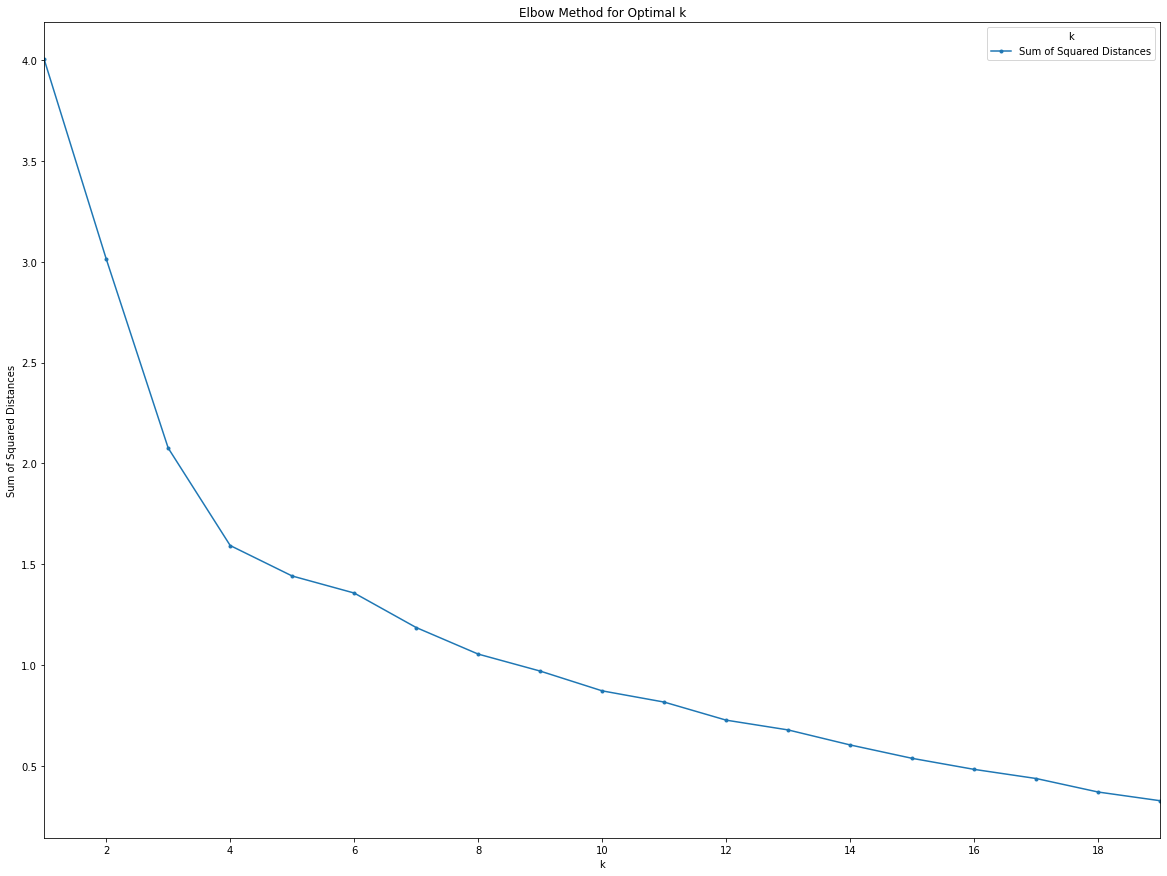

In [37]:
optimal_k.plot(kind='line', figsize=(20, 15), marker='.')
plt.title('Elbow Method for Optimal k')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [38]:
# set number of clusters
k = 4

# run k-means clustering
km = KMeans(n_clusters=k, random_state=0).fit(toronto_clustering)

# check cluster labels
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       3, 0, 1, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [39]:
# apply cluster labels to neighborhoods_venues_sorted
merged = neighborhoods_venues_sorted
merged['Cluster'] = km.labels_
merged.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,Restaurant,Asian Restaurant,Burger Joint,American Restaurant,Hotel,0
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Bakery,Steakhouse,Cheese Shop,Seafood Restaurant,Café,Fish Market,0
2,"Brockton, Exhibition Place, Parkdale Village",Yoga Studio,Breakfast Spot,Café,Coffee Shop,Bar,Burrito Place,Restaurant,Caribbean Restaurant,Climbing Gym,Pet Store,0
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place,Restaurant,0
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Bar,Plane,Coffee Shop,Sculpture Garden,Boutique,Boat or Ferry,0


In [40]:
# add neighborhood coordinates
merged[['Latitude', 'Longitude']] = neighborhood_coordinates[['Latitude', 'Longitude']]
merged.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster,Latitude,Longitude
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,Restaurant,Asian Restaurant,Burger Joint,American Restaurant,Hotel,0,43.806686,-79.194353
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Bakery,Steakhouse,Cheese Shop,Seafood Restaurant,Café,Fish Market,0,43.784535,-79.160497
2,"Brockton, Exhibition Place, Parkdale Village",Yoga Studio,Breakfast Spot,Café,Coffee Shop,Bar,Burrito Place,Restaurant,Caribbean Restaurant,Climbing Gym,Pet Store,0,43.763573,-79.188711
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place,Restaurant,0,43.770992,-79.216917
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Bar,Plane,Coffee Shop,Sculpture Garden,Boutique,Boat or Ferry,0,43.773136,-79.239476


In [41]:
merged.dtypes

Neighborhood               object
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
Cluster                     int32
Latitude                  float64
Longitude                 float64
dtype: object

## Visualize the clusters

In [42]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'],
                                 merged['Longitude'],
                                 merged['Neighborhood'],
                                 merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],
                       radius=5,
                       popup=label,
                       color=rainbow[cluster-1],
                       fill=True,
                       fill_color=rainbow[cluster-1],
                       fill_opacity=0.7).add_to(map_clusters)

map_clusters

## Examine the clusters
### Cluster 1

In [43]:
merged.loc[merged['Cluster'] == 0, merged.columns[[0] + list(range(1, merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster,Latitude,Longitude
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Thai Restaurant,Restaurant,Asian Restaurant,Burger Joint,American Restaurant,Hotel,0,43.806686,-79.194353
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Bakery,Steakhouse,Cheese Shop,Seafood Restaurant,Café,Fish Market,0,43.784535,-79.160497
2,"Brockton, Exhibition Place, Parkdale Village",Yoga Studio,Breakfast Spot,Café,Coffee Shop,Bar,Burrito Place,Restaurant,Caribbean Restaurant,Climbing Gym,Pet Store,0,43.763573,-79.188711
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place,Restaurant,0,43.770992,-79.216917
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Bar,Plane,Coffee Shop,Sculpture Garden,Boutique,Boat or Ferry,0,43.773136,-79.239476
5,"Cabbagetown, St. James Town",Café,Coffee Shop,Italian Restaurant,Pub,Pizza Place,Restaurant,Bakery,Grocery Store,Chinese Restaurant,Japanese Restaurant,0,43.744734,-79.239476
6,Central Bay Street,Coffee Shop,Café,Ice Cream Shop,Italian Restaurant,Sandwich Place,Burger Joint,Sushi Restaurant,Middle Eastern Restaurant,Salad Place,Bubble Tea Shop,0,43.727929,-79.262029
7,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Bar,Chinese Restaurant,Vietnamese Restaurant,Mexican Restaurant,Dumpling Restaurant,Bakery,Coffee Shop,Arts & Crafts Store,0,43.711112,-79.284577
8,Christie,Café,Grocery Store,Park,Athletics & Sports,Baby Store,Italian Restaurant,Restaurant,Nightclub,Diner,Coffee Shop,0,43.716316,-79.239476
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Gym,Smoke Shop,Bubble Tea Shop,Burger Joint,Café,0,43.692657,-79.264848


### Cluster 2

In [44]:
merged.loc[merged['Cluster'] == 1, merged.columns[[0] + list(range(1, merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster,Latitude,Longitude
24,"Moore Park, Summerhill East",Restaurant,Wings Joint,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,1,43.782736,-79.442259


### Cluster 3

In [45]:
merged.loc[merged['Cluster'] == 2, merged.columns[[0] + list(range(1, merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster,Latitude,Longitude
28,Roselawn,Garden,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,2,43.754328,-79.442259


### Cluster 4

In [46]:
merged.loc[merged['Cluster'] == 3, merged.columns[[0] + list(range(1, merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster,Latitude,Longitude
17,"Forest Hill North, Forest Hill West",Sushi Restaurant,Park,Trail,Jewelry Store,Bus Line,Wings Joint,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,3,43.803762,-79.363452
22,Lawrence Park,Bus Line,Park,Swim School,Wings Joint,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,3,43.770120,-79.408493
27,Rosedale,Park,Playground,Trail,Building,Wings Joint,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,3,43.725900,-79.340923


## Re-cluster the neighborhoods
### More relevant information can be found by clustering the neighborhoods based on venues similar to our proposed jazz club

In [47]:
# search for neighborhoods with venues similar to our hypothetical business
len(toronto_grouped[toronto_grouped['Jazz Club'] > 0])

5

In [48]:
len(toronto_grouped[toronto_grouped['Cajun / Creole Restaurant'] > 0])

1

In [49]:
len(toronto_grouped[toronto_grouped['Southern / Soul Food Restaurant'] > 0])

1

In [50]:
len(toronto_grouped[toronto_grouped['BBQ Joint'] > 0])

4

In [51]:
len(toronto_grouped[toronto_grouped['Performing Arts Venue'] > 0])

3

In [52]:
# create a dataframe showing the frequency of these types of venues
toronto_poi = toronto_grouped[['Neighborhood',
                               'Jazz Club',
                              'Cajun / Creole Restaurant',
                              'Southern / Soul Food Restaurant',
                              'BBQ Joint',
                              'Performing Arts Venue']]
toronto_poi.head()

,Neighborhood,Jazz Club,Cajun / Creole Restaurant,Southern / Soul Food Restaurant,BBQ Joint,Performing Arts Venue
0,"Adelaide, King, Richmond",0.010000,0.0,0.0,0.000000,0.000000
1,Berczy Park,0.017544,0.0,0.0,0.017544,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.0,0.0,0.000000,0.043478
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.0,0.0,0.000000,0.000000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.0,0.0,0.000000,0.000000


In [53]:
toronto_poi.dtypes

Neighborhood                        object
Jazz Club                          float64
Cajun / Creole Restaurant          float64
Southern / Soul Food Restaurant    float64
BBQ Joint                          float64
Performing Arts Venue              float64
dtype: object

In [54]:
# re-cluster neighborhoods based on new dataframe
new_clusters = toronto_poi.drop('Neighborhood', 1)

new_sum_sq = []
values = range(1, 10)
for value in values:
    kmeans = KMeans(n_clusters=value)
    kmeans = kmeans.fit(new_clusters)
    new_sum_sq.append(kmeans.inertia_)

In [55]:
new_optimum = pd.DataFrame(data=new_sum_sq, columns=['Sum of Squared Distances'], index=values)
new_optimum.rename_axis('k', axis='columns', inplace=True)

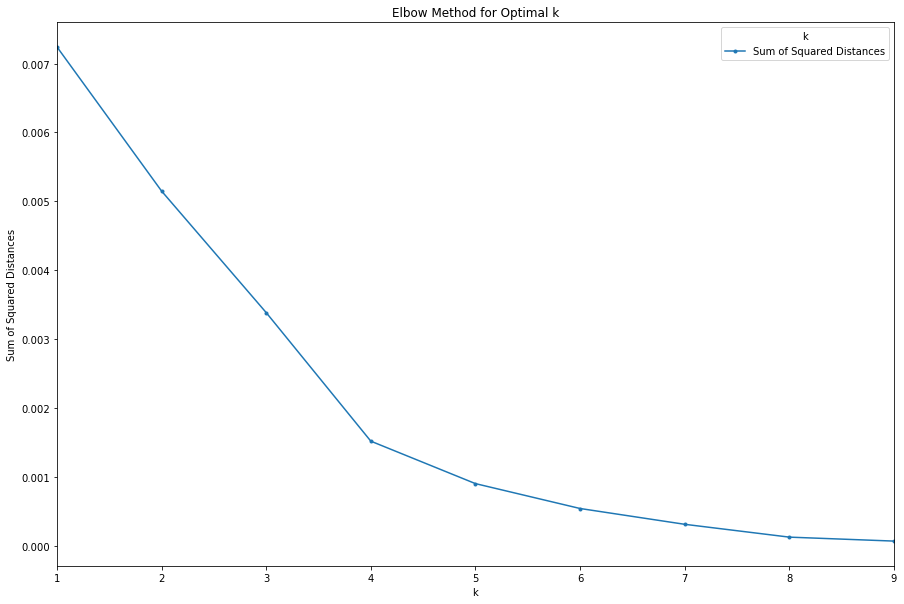

In [56]:
new_optimum.plot(kind='line', figsize=(15, 10), marker='.')
plt.title('Elbow Method for Optimal k')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [57]:
k = 4

km_2 = KMeans(n_clusters=k, random_state=0).fit(new_clusters)

km_2.labels_

array([1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1], dtype=int32)

In [58]:
merged_2 = toronto_poi
merged_2[['Latitude', 'Longitude']] = neighborhood_coordinates[['Latitude', 'Longitude']]
merged_2['Cluster'] = km_2.labels_
merged_2 = merged_2.sort_values('Cluster')
merged_2.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,Jazz Club,Cajun / Creole Restaurant,Southern / Soul Food Restaurant,BBQ Joint,Performing Arts Venue,Latitude,Longitude,Cluster
2,"Brockton, Exhibition Place, Parkdale Village",0.00,0.0,0.0,0.0,0.043478,43.763573,-79.188711,0
20,"Harbourfront, Regent Park",0.00,0.0,0.0,0.0,0.018868,43.757490,-79.374714,0
0,"Adelaide, King, Richmond",0.01,0.0,0.0,0.0,0.000000,43.806686,-79.194353,1
19,"Harbourfront East, Toronto Islands, Union Station",0.00,0.0,0.0,0.0,0.010000,43.786947,-79.385975,1
22,Lawrence Park,0.00,0.0,0.0,0.0,0.000000,43.770120,-79.408493,1


## Visualize the new clusters

In [59]:
cluster_map_2 = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(merged_2['Latitude'],
                                 merged_2['Longitude'],
                                 merged_2['Neighborhood'],
                                 merged_2['Cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster+1))
    folium.CircleMarker([lat, lon],
                       radius=5,
                       popup=label,
                       color=rainbow[cluster-1],
                       fill=True,
                       fill_color=rainbow[cluster-1],
                       fill_opacity=0.7).add_to(cluster_map_2)

cluster_map_2

## Examine the new clusters
### Cluster 1

In [60]:
merged_2.loc[merged_2['Cluster'] == 0, merged_2.columns[[0] + list(range(1, merged_2.shape[1]))]]

,Neighborhood,Jazz Club,Cajun / Creole Restaurant,Southern / Soul Food Restaurant,BBQ Joint,Performing Arts Venue,Latitude,Longitude,Cluster
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0,0.0,0.0,0.043478,43.763573,-79.188711,0
20,"Harbourfront, Regent Park",0.0,0.0,0.0,0.0,0.018868,43.757490,-79.374714,0


### Cluster 2

In [61]:
merged_2.loc[merged_2['Cluster'] == 1, merged_2.columns[[0] + list(range(1, merged_2.shape[1]))]]

,Neighborhood,Jazz Club,Cajun / Creole Restaurant,Southern / Soul Food Restaurant,BBQ Joint,Performing Arts Venue,Latitude,Longitude,Cluster
0,"Adelaide, King, Richmond",0.01,0.0,0.000000,0.0,0.00,43.806686,-79.194353,1
19,"Harbourfront East, Toronto Islands, Union Station",0.00,0.0,0.000000,0.0,0.01,43.786947,-79.385975,1
22,Lawrence Park,0.00,0.0,0.000000,0.0,0.00,43.770120,-79.408493,1
23,"Little Portugal, Trinity",0.00,0.0,0.015385,0.0,0.00,43.752758,-79.400049,1
24,"Moore Park, Summerhill East",0.00,0.0,0.000000,0.0,0.00,43.782736,-79.442259,1
25,North Toronto West,0.00,0.0,0.000000,0.0,0.00,43.753259,-79.329656,1
26,"Parkdale, Roncesvalles",0.00,0.0,0.000000,0.0,0.00,43.745906,-79.352188,1
27,Rosedale,0.00,0.0,0.000000,0.0,0.00,43.725900,-79.340923,1
28,Roselawn,0.00,0.0,0.000000,0.0,0.00,43.754328,-79.442259,1
29,"Runnymede, Swansea",0.00,0.0,0.000000,0.0,0.00,43.767980,-79.487262,1


### Cluster 3

In [62]:
merged_2.loc[merged_2['Cluster'] == 2, merged_2.columns[[0] + list(range(1, merged_2.shape[1]))]]

,Neighborhood,Jazz Club,Cajun / Creole Restaurant,Southern / Soul Food Restaurant,BBQ Joint,Performing Arts Venue,Latitude,Longitude,Cluster
31,St. James Town,0.010000,0.0,0.0,0.020000,0.0,43.739015,-79.506944,2
32,Stn A PO Boxes 25 The Esplanade,0.010204,0.0,0.0,0.010204,0.0,43.728496,-79.495697,2
34,"The Annex, North Midtown, Yorkville",0.000000,0.0,0.0,0.041667,0.0,43.725882,-79.315572,2
1,Berczy Park,0.017544,0.0,0.0,0.017544,0.0,43.784535,-79.160497,2


### Cluster 4

In [63]:
merged_2.loc[merged_2['Cluster'] == 3, merged_2.columns[[0] + list(range(1, merged_2.shape[1]))]]

,Neighborhood,Jazz Club,Cajun / Creole Restaurant,Southern / Soul Food Restaurant,BBQ Joint,Performing Arts Venue,Latitude,Longitude,Cluster
21,"High Park, The Junction South",0.0,0.043478,0.0,0.0,0.0,43.789053,-79.408493,3


## Conclusions:
A cursory look at the data confirms the initial assessment of Toronto as a city with a niche that is ready to be filled. Toronto has a dearth of jazz clubs and performing arts venues, with neither category being counted among the ten most popular venue types in any neighborhood. Indeed, a basic search reveals only five venues catering specifically to jazz artists and their audiences. Furthermore, the second, more focused segmentation reveals that the jazz clubs that do exist within Toronto are not well distributed throughout the city, being largely relegated to outlying neighborhoods to the east and west.

Similarly, Toronto is home to few restaurants specializing in the renowned cuisines of the southern United States: barbecue, Cajun/creole, and soul food. For only a single neighborhood, High Park/The Junction South, does the Cajun/creole style find itself as the tenth most popular venue type. Toronto eateries are dominated by more generic restaurants and coffee shops, with ethnic establishments dominated by sushi and other Asian cuisines. 

The relative rarity and poor distribution of these types of venues makes it easy to point to Toronto as an untapped market for an establishment that serves up southern-style cooking and live jazz. Furthermore, the clustering analysis reveals a handful of caveats: neighborhoods that our hypothetical restaurateur would do well to avoid in selecting a location for a new jazz club, so as to maximize their market share. In short, Cluster 2 of the second cluster analysis is the most promising. Not only does is it the largest cluster with 31 neighborhoods, but it is virtually devoid of the types of venues identified as potential competitors. The only neighborhoods in Cluster 2 that should be avoided are those which already feature jazz clubs: Adelaide/King/Richmond and Commerce Court/Victoria Hotel.

Cluster 1 also presents viable options, with Harbourfront/Regent Park being perhaps the optimal choice. Apart from an utter lack of competition within the neighborhood, it is also situated near the city center, away from the slight concentrations of extant jazz venues. Neighborhoods in Clusters 3 and 4 should be avoided on the grounds that they contain higher proportions of potential business competitors.